In [3]:
import math
import pandas as pd
import os

from biopandas.pdb import PandasPdb
import numpy as np

import torch

from matplotlib import pyplot as plt
import scipy.spatial as spa
from tqdm import tqdm

/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Input: expects 3xN matrix of points
# Returns such R, t so that rmsd(R @ A + t, B) is min
# Uses Kabsch algorithm (https://en.wikipedia.org/wiki/Kabsch_algorithm)
# R = 3x3 rotation matrix
# t = 3x1 column vector
# This already takes residue identity into account.
def rigid_transform_Kabsch_3D(A, B):
    assert A.shape[1] == B.shape[1]
    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")
    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")


    # find mean column wise: 3 x 1
    centroid_A = np.mean(A, axis=1, keepdims=True)
    centroid_B = np.mean(B, axis=1, keepdims=True)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ Bm.T

    # find rotation
    U, S, Vt = np.linalg.svd(H)

    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        # print("det(R) < R, reflection detected!, correcting for it ...")
        SS = np.diag([1.,1.,-1.])
        R = (Vt.T @ SS) @ U.T
    assert math.fabs(np.linalg.det(R) - 1) < 1e-5

    t = -R @ centroid_A + centroid_B
    return R, t

In [5]:
def compute_rmsd(pred, true):
    return np.sqrt(np.mean(np.sum((pred - true) ** 2, axis=1)))

In [6]:
def get_rmsd_summary(rmsds):
    rmsds_np = np.array(rmsds)
    return {
        'mean': np.mean(rmsds_np),
        'median': np.median(rmsds_np),
        'std': np.std(rmsds_np),
        'lt1': 100 * (rmsds_np < 1.0).sum() / len(rmsds_np),
        'lt2': 100 * (rmsds_np < 2.0).sum() / len(rmsds_np),
        'lt5': 100 * (rmsds_np < 5.0).sum() / len(rmsds_np),
        'lt10': 100 * (rmsds_np < 10.0).sum() / len(rmsds_np)
    }

In [7]:
class RMSDComputer():
    def __init__(self):
        self.complex_rmsd_list = []
        self.ligand_rmsd_list = []
    
    def update_all_rmsd(self, ligand_coors_pred, ligand_coors_true, receptor_coors):
        complex_rmsd = self.update_complex_rmsd(ligand_coors_pred, ligand_coors_true, receptor_coors)
        ligand_rmsd = self.update_ligand_rmsd(ligand_coors_pred, ligand_coors_true)
        return complex_rmsd, ligand_rmsd

    def update_complex_rmsd(self, ligand_coors_pred, ligand_coors_true, receptor_coors):
        complex_coors_pred = np.concatenate((ligand_coors_pred, receptor_coors), axis=0)
        complex_coors_true = np.concatenate((ligand_coors_true, receptor_coors), axis=0)

        R,t = rigid_transform_Kabsch_3D(complex_coors_pred.T, complex_coors_true.T)
        complex_coors_pred_aligned = (R @ complex_coors_pred.T + t).T

        complex_rmsd = compute_rmsd(complex_coors_pred_aligned, complex_coors_true)
        self.complex_rmsd_list.append(complex_rmsd)

        return complex_rmsd

    def update_ligand_rmsd(self, ligand_coors_pred, ligand_coors_true):
        ligand_rmsd = compute_rmsd(ligand_coors_pred, ligand_coors_true)
        self.ligand_rmsd_list.append(ligand_rmsd)
        
        return ligand_rmsd
    
    def summarize(self):
        ligand_rmsd_summarized = get_rmsd_summary(self.ligand_rmsd_list) if self.ligand_rmsd_list else None
        complex_rmsd_summarized = get_rmsd_summary(self.complex_rmsd_list)
        return ligand_rmsd_summarized, complex_rmsd_summarized

In [8]:
input_dir = '/data/rsg/nlp/sdobers/data/DIPS/hdock' 

In [9]:
directories_df = pd.read_csv("/data/rsg/nlp/sdobers/data/DIPS/data_file.csv")
directories_df = directories_df[directories_df.split == "test"]
directories = [f"{input_dir}/{path}".replace('.dill', '') for path in directories_df.path.values]
print(len(directories))
directories = [directory for directory in directories if os.path.exists(f"{directory}/output.pdb")]
print(len(directories))

971
962


In [10]:
def convert(model, atoms_to_keep):
    df = model.df['ATOM']
    df = df[df.atom_name.apply(lambda atom_name: atom_name in atoms_to_keep)]
    return df[['x_coord', 'y_coord', 'z_coord']].to_numpy().squeeze().astype(np.float32)

def get_coords(pdb_file, atoms_to_keep, num_poses=1):
    ppdb = PandasPdb().read_pdb(pdb_file)
    models = [ppdb.get_model(i) for i in range(1, num_poses + 1)]
    return [convert(model, atoms_to_keep) for model in models]

In [11]:
directories[10]

'/data/rsg/nlp/sdobers/data/DIPS/hdock/pj/3pja.pdb2_1'

In [12]:
atoms_to_keep = ("CA", )

In [14]:
from multiprocessing import Process, Manager

pd.set_option('mode.chained_assignment', None) # Remove annoying warnings

def extract_coordinates(sync_list_coors, directory):  # the managed list `L` passed explicitly.
    ligand_model_file = f"{directory}/output.pdb"
    ligand_gt_file = f"{directory}/ligand_gt.pdb"
    receptor = f"{directory}/receptor.pdb"

    ligand_model_coords_all_poses = get_coords(ligand_model_file, atoms_to_keep, num_poses=5)
    ligand_gt_coords_all_poses = get_coords(ligand_gt_file, atoms_to_keep, num_poses=1) * 5
    receptor_coords_all_poses = get_coords(receptor, atoms_to_keep, num_poses=1) * 5
    
    
    ligand_model_pocket_coors_all_poses = []
    ligand_gt_pocket_coors_all_poses = []
    receptor_pocket_coors_all_poses = []
    for ligand_model_coords, ligand_gt_coords, receptor_coords in zip(ligand_model_coords_all_poses, ligand_gt_coords_all_poses, receptor_coords_all_poses):
        

        ligand_receptor_distance = spa.distance.cdist(ligand_gt_coords, receptor_coords)
        positive_tuple = np.where(ligand_receptor_distance < 8.)
    
        active_ligand = positive_tuple[0]
        active_receptor = positive_tuple[1]
    
        ligand_model_pocket_coors = ligand_model_coords[active_ligand, :]
        ligand_gt_pocket_coors = ligand_gt_coords[active_ligand, :]
        receptor_pocket_coors = receptor_coords[active_receptor, :]
        
        ligand_model_pocket_coors_all_poses.append(ligand_model_pocket_coors)
        ligand_gt_pocket_coors_all_poses.append(ligand_gt_pocket_coors)
        receptor_pocket_coors_all_poses.append(receptor_pocket_coors)
    
    
    sync_list_coors.append((ligand_model_coords_all_poses, ligand_gt_coords_all_poses, receptor_coords_all_poses, 
                                 ligand_model_pocket_coors_all_poses, ligand_gt_pocket_coors_all_poses, receptor_pocket_coors_all_poses))

num_test_files = len(directories)

with Manager() as manager:
    sync_list_coors = manager.list()  # <-- can be shared between processes.
    
    for batch in tqdm(range(16), total = 16):
        processes = []
        
        for i in range(64):
            dir_number = batch * 64 + i
            if dir_number >= num_test_files:
                continue
                
            p = Process(target=extract_coordinates, args=(sync_list_coors, directories[dir_number]))  # Passing the list
            p.start()
            processes.append(p)
            
        for p in processes:
            p.join()
    list_coors = list(sync_list_coors)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [04:28<00:00, 16.76s/it]


In [16]:
meter = RMSDComputer()

Irmsd_meter = RMSDComputer()

all_crmsd = []
all_irmsd = []
all_lrmsd = []

num_test_files = len(list_coors)

for coors in tqdm(list_coors):
    ligand_model_coords_all_poses, ligand_gt_coords_all_poses, receptor_coords_all_poses, ligand_model_pocket_coors_all_poses, ligand_gt_pocket_coors_all_poses, receptor_pocket_coors_all_poses = coors
    
    
    crmsds, lrmsds, irmsds = [], [], []
    for i in range(5):
        crmsd, lrmsd = meter.update_all_rmsd(np.array(ligand_model_coords_all_poses[i]), np.array(ligand_gt_coords_all_poses[i]), np.array(receptor_coords_all_poses[i]))
        irmsd = Irmsd_meter.update_complex_rmsd(np.array(ligand_model_pocket_coors_all_poses[i]), np.array(ligand_gt_pocket_coors_all_poses[i]), np.array(receptor_pocket_coors_all_poses[i]))
        
        crmsds.append(crmsd)
        lrmsds.append(lrmsd)
        irmsds.append(irmsd)
    
    all_crmsd.append(crmsds)
    all_lrmsd.append(lrmsds)
    all_irmsd.append(irmsds)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 962/962 [00:01<00:00, 658.30it/s]


In [18]:
top5_crmsd = [min(crmsds) for crmsds in all_crmsd]
top5_lrmsd = [min(lrmsds) for lrmsds in all_lrmsd]
top5_irmsd = [min(irmsds) for irmsds in all_irmsd]

In [19]:
crmsd = get_rmsd_summary(top5_crmsd)
lrmsd = get_rmsd_summary(top5_lrmsd)
irmsd = get_rmsd_summary(top5_irmsd)

In [24]:
print(f'Number of samples:\t\t\t{num_test_files}')
print()
print(f"Top 5 Ligand RMSD median/mean:\t\t{lrmsd['median']:.3}/{lrmsd['mean']:.3} ± {lrmsd['std']:.3}")
print(f"Top 5 Complex RMSD median/mean:\t\t{crmsd['median']:.3}/{crmsd['mean']:.3} ± {crmsd['std']:.3}")
print(f"Top 5 Interface RMSD median/mean:\t{irmsd['median']:.3}/{irmsd['mean']:.3} ± {irmsd['std']:.3}")
print()
print(f"Top 5 Ligand lt1/lt2/lt5/lt10,:\t\t{lrmsd['lt1']:.3}%/{lrmsd['lt2']:.3}%/{lrmsd['lt5']:.3}%/{lrmsd['lt10']:.3}%")
print(f"Top 5 Complex lt1/lt2/lt5/lt10,:\t{crmsd['lt1']:.3}%/{crmsd['lt2']:.3}%/{crmsd['lt5']:.3}%/{crmsd['lt10']:.3}%")
print(f"Top 5 Interface lt1/lt2/lt5/lt10,:\t{irmsd['lt1']:.3}%/{irmsd['lt2']:.3}%/{irmsd['lt5']:.3}%/{irmsd['lt10']:.3}%")

Number of samples:			962

Top 5 Ligand RMSD median/mean:		0.962/12.5 ± 20.3
Top 5 Complex RMSD median/mean:		0.388/5.22 ± 8.48
Top 5 Interface RMSD median/mean:	0.315/3.71 ± 6.28

Top 5 Ligand lt1/lt2/lt5/lt10,:		51.0%/66.3%/69.4%/70.4%
Top 5 Complex lt1/lt2/lt5/lt10,:	68.1%/69.4%/70.6%/74.4%
Top 5 Interface lt1/lt2/lt5/lt10,:	69.6%/70.3%/72.7%/83.9%


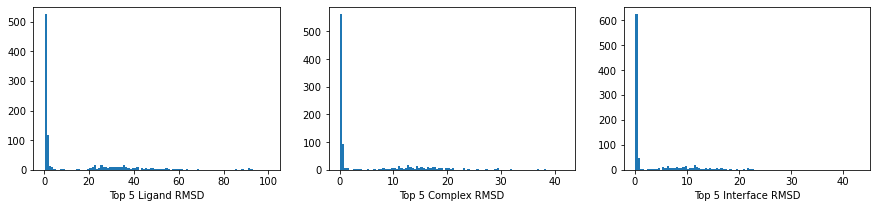

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (15, 3))
_ = ax[0].hist(top5_lrmsd, bins=100)
_ = ax[0].set(xlabel="Top 5 Ligand RMSD")

_ = ax[1].hist(top5_crmsd, bins=100)
_ = ax[1].set(xlabel="Top 5 Complex RMSD")

_ = ax[2].hist(top5_irmsd, bins=100)
_ = ax[2].set(xlabel="Top 5 Interface RMSD")

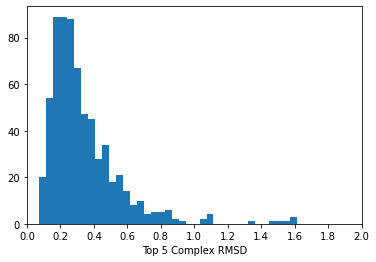

In [28]:
_ = plt.hist(top5_crmsd, bins=1000)
_ = plt.xlabel("Top 5 Complex RMSD")
_ = plt.xlim([0, 2])
_ = plt.xticks(np.linspace(0, 2, 11))

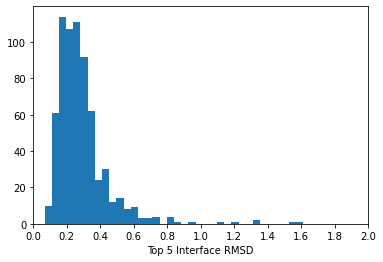

In [29]:
_ = plt.hist(top5_irmsd, bins=1000)
_ = plt.xlabel("Top 5 Interface RMSD")
_ = plt.xlim([0, 2])
_ = plt.xticks(np.linspace(0, 2, 11))

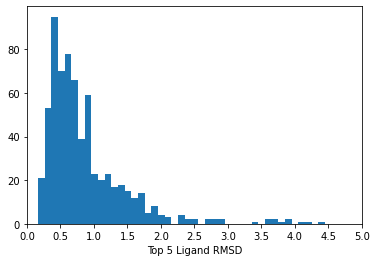

In [30]:
_ = plt.hist(top5_lrmsd, bins=1000)
_ = plt.xlabel("Top 5 Ligand RMSD")
_ = plt.xlim([0, 5])
_ = plt.xticks(np.linspace(0, 5, 11))